Mean Squared Error: 1518935.7694205889
Percentage of Samples within 10.0%: 26.30%
Model saved at C:\Users\cassiorodrigo.crisfa\Documents\GitHub\xtream-ai-assignment\Cristani\model.joblib
Total original samples: 1000
Total samples after filtering ( 10.0 %): 314 (31.40%)
Total overestimated samples after filtering (> 0 and margin 0.1): 191 (19.10%)
Total underestimated samples after filtering (< 0 and margin 0.1): 123 (12.30%)
Average absolute difference for overestimated samples after filtering: 1348.44
Standard deviation for overestimated samples after filtering: 1111.34
Average absolute difference for underestimated samples after filtering: 2130.64
Standard deviation for underestimated samples after filtering: 1320.43


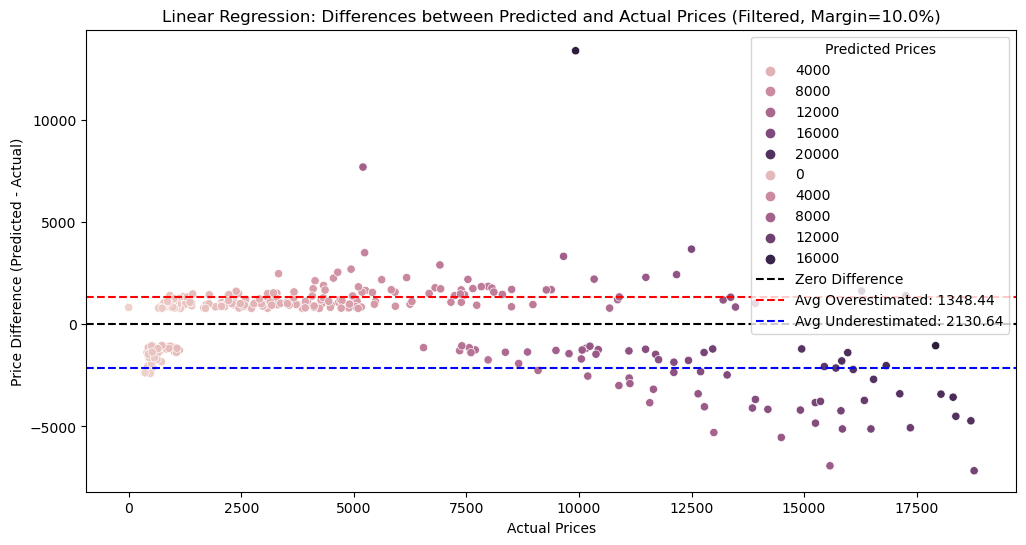

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import shutil
import os
import time

def plot_model(data_path, model, y_test, y_pred, margin, evaluated_sample_index):
     # Create a DataFrame for visualization
    df_visualization = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})

    # Calculate the differences between predicted and actual prices
    df_visualization['Price Difference'] = df_visualization['Predicted Prices'] - df_visualization['Actual Prices']

    # Calculate the absolute differences
    df_visualization['Absolute Difference'] = abs(df_visualization['Price Difference'])

    # Set a threshold for underestimation (adjust as needed)
    underestimate_threshold = 0

    # Identify underestimated samples
    df_visualization['Underestimated'] = df_visualization['Price Difference'] < underestimate_threshold

    # Identify overestimated samples
    df_visualization['Overestimated'] = df_visualization['Price Difference'] > underestimate_threshold

    # Filter out samples within a margin 
    margin = 0.10 
    avg_abs_diff_overestimated = df_visualization.loc[df_visualization['Overestimated'], 'Absolute Difference'].mean()
    avg_abs_diff_underestimated = df_visualization.loc[df_visualization['Underestimated'], 'Absolute Difference'].mean()

    df_filtered_overestimated = df_visualization.loc[df_visualization['Overestimated'] & (df_visualization['Absolute Difference'] > (1 + margin) * avg_abs_diff_overestimated)]
    df_filtered_underestimated = df_visualization.loc[df_visualization['Underestimated'] & (df_visualization['Absolute Difference'] > (1 + margin) * avg_abs_diff_underestimated)]

    # Count the number of original samples
    total_samples = len(df_visualization)

    # Count the number of samples after filtering
    total_samples_filtered = len(df_filtered_overestimated) + len(df_filtered_underestimated)
    total_overestimated_filtered = len(df_filtered_overestimated)
    total_underestimated_filtered = len(df_filtered_underestimated)

    # Calculate average and standard deviation for overestimated and underestimated samples after filtering
    avg_overestimated_filtered = df_filtered_overestimated['Absolute Difference'].mean()
    std_overestimated_filtered = df_filtered_overestimated['Absolute Difference'].std()

    avg_underestimated_filtered = df_filtered_underestimated['Absolute Difference'].mean()
    std_underestimated_filtered = df_filtered_underestimated['Absolute Difference'].std()

    # Print the number of original samples
    print(f'Total original samples: {total_samples}')

    # Print the number and percentage of samples after filtering
    print(f'Total samples after filtering ( {100*margin} %): {total_samples_filtered} ({total_samples_filtered / total_samples * 100:.2f}%)')
    print(f'Total overestimated samples after filtering (> {underestimate_threshold} and margin {margin}): {total_overestimated_filtered} '
          f'({total_overestimated_filtered / total_samples * 100:.2f}%)')
    print(f'Total underestimated samples after filtering (< {underestimate_threshold} and margin {margin}): {total_underestimated_filtered} '
          f'({total_underestimated_filtered / total_samples * 100:.2f}%)')

    # Print average and standard deviation for overestimated and underestimated samples after filtering
    print(f'Average absolute difference for overestimated samples after filtering: {avg_overestimated_filtered:.2f}')
    print(f'Standard deviation for overestimated samples after filtering: {std_overestimated_filtered:.2f}')

    print(f'Average absolute difference for underestimated samples after filtering: {avg_underestimated_filtered:.2f}')
    print(f'Standard deviation for underestimated samples after filtering: {std_underestimated_filtered:.2f}')

    # Plot the differences with actual prices on the x-axis after filtering
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Actual Prices', y='Price Difference', hue='Predicted Prices', data=df_filtered_overestimated)
    sns.scatterplot(x='Actual Prices', y='Price Difference', hue='Predicted Prices', data=df_filtered_underestimated)
    plt.axhline(y=0, color='black', linestyle='--', label='Zero Difference')
    plt.axhline(y=avg_overestimated_filtered, color='red', linestyle='--', label=f'Avg Overestimated: {avg_overestimated_filtered:.2f}')
    plt.axhline(y=-avg_underestimated_filtered, color='blue', linestyle='--', label=f'Avg Underestimated: {avg_underestimated_filtered:.2f}')

    plt.xlabel('Actual Prices')
    plt.ylabel('Price Difference (Predicted - Actual)')
    plt.title(f'Linear Regression: Differences between Predicted and Actual Prices (Filtered, Margin={margin * 100}%)')
    plt.legend(title='Predicted Prices')
    plt.show()

def converting_to_numeral(csv_path):
    # Create a backup of the original file
    backup_path = csv_path.replace('.csv', '_backup.csv')
    shutil.copy(csv_path, backup_path)

    # Read the original CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Mapping dictionaries for 'cut', 'clarity', and 'color'
    cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
    clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
    color_mapping = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7, 'K': 8, 'L': 9, 'M': 10,
                     'N': 11, 'O': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20,
                     'X': 21, 'Y': 22, 'Z': 23}

    # Convert 'cut', 'clarity', and 'color' to integers
    df['cut'] = df['cut'].map(cut_mapping)
    df['clarity'] = df['clarity'].map(clarity_mapping)
    df['color'] = df['color'].map(color_mapping)

    # Create 'color_classification' column 
    color_classification_mapping = {'Colorless': 1, 'Near Colorless': 2, 'Faint Yellow': 3, 'Very Light Yellow': 4, 'Light Yellow': 5}
    df['color_classification'] = df['color_classification'].map(color_classification_mapping)

    # Calculate 'z_depth' and 'table_width' columns
    df['z_depth'] = df['depth'] * df['z'] * 100
    df['table_width'] = df['table'] * df['x'] * 100

    # Drop rows with NaN values (if any)
    df.dropna(inplace=True)

    # Save the updated DataFrame to a new CSV file
    updated_csv_path = csv_path.replace('.csv', '_updated.csv')
    df.to_csv(updated_csv_path, index=False)

    # Create 'color_classification' column 
    df['color_classification'] = pd.Series(dtype='int')
    df.loc[(df['color'] >= 1) & (df['color'] <= 3), 'color_classification'] = 1 # 'Colorless'
    df.loc[(df['color'] >= 4) & (df['color'] <= 7), 'color_classification'] = 2 #'Near Colorless'
    df.loc[(df['color'] >= 8) & (df['color'] <= 10), 'color_classification'] = 3 #'Faint Yellow'
    df.loc[(df['color'] >= 11) & (df['color'] <= 15), 'color_classification'] = 4 #'Very Light Yellow'
    df.loc[(df['color'] >= 16) & (df['color'] <= 23), 'color_classification'] = 5 #'Light Yellow'

    return updated_csv_path

def regularize_original_file(dataset_path):
    # List of columns to keep
    columns_regularized = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price']
    
    # Read the CSV file into a DataFrame
    data = pd.read_csv(dataset_path)
    
    # Drop columns not in the specified list
    columns_to_drop = [col for col in data.columns if col not in columns_regularized]
    data.drop(columns=columns_to_drop, inplace=True)
    
    # Save the regularized DataFrame to a new CSV file
    regularized_csv_path = dataset_path.replace('.csv', '_regularized.csv')
    data.to_csv(regularized_csv_path, index=False)
    
    return regularized_csv_path
               
def test_reg_file(dataset_path):
    # columns of regularized file
    columns_regularized = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price']
    
    data = pd.read_csv(dataset_path)
    
    # Check if columns are equal to the regularized list
    if list(data.columns) == columns_regularized:
        return True
    else:
        return False

def explain_model(model, explainer, X_test, instance_index, feature_names):

    instance = X_test.iloc[instance_index].values
    prediction = model.predict([instance])[0]

    explanation = explainer.explain_instance(instance, model.predict, num_features=len(feature_names))

    # Print explanation
    print("LIME Explanation:")
    print(f"Predicted Price: {prediction}")
    print("Feature Weights:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")
    explanation.show_in_notebook()
    
import os
import time

def buffer_feeder(data_directory, model_path, buffer_sleep_time, margin):
    while True:
        for dataset_file in os.listdir(data_directory):
            dataset_path = os.path.join(data_directory, dataset_file)
            
            dataset = converting_to_numeral(dataset_path)
            # Drop columns if not regularized
            if test_reg_file(dataset_path) == False:
                dataset_path = regularize_original_file(dataset_path)
            
            # Load and preprocess the data
            X_train, X_test, y_train, y_test = split_price(dataset_path)

            # Train the model
            model = train_model(X_train, y_train)
            y_pred = model.predict(X_test)
            # Evaluate the model
            mse, percentage_within_margin = evaluate_model(model, X_test, y_test, margin)
            print(f'Mean Squared Error: {mse}')
            print(f'Percentage of Samples within {margin * 100}%: {percentage_within_margin:.2f}%')

            # Save the trained model
            save_model(model, model_path)
            plot_model(dataset_path, model, y_test, y_pred, margin, evaluated_sample_index=1)
            explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
            
            while True:
                user_input = input("Enter the number of the samples to explain (or 'x' to exit): ").lower()
                if user_input == 'x':
                    break  # Break out of the loop if the user wants to exit
                try:
                    sample = int(user_input)
                    # Call the explain_model function
                    explain_model(model, explainer, X_test, sample, X_train.columns)
                except ValueError:
                    print("Invalid input. Please enter a valid integer or 'x' to exit.")

            # Ask if the user needs another explanation for a new sample
            another_explanation = input("Do you need explain another sample? (y/n): ").lower()
            if another_explanation != 'y':
                break

            # Move the processed dataset file to another directory or delete it
            processed_dataset_path = os.path.join(data_directory, 'processed', dataset_file)
            os.rename(dataset_path, processed_dataset_path)
            
            print(f"Waiting for {buffer_sleep_time} seconds before checking for new datasets...")
            for _ in range(buffer_sleep_time):
                time.sleep(1)  # Sleep for 1 second, repeated buffer_sleep_time times
                
                user_input = input("Enter 'x' to exit or press Enter to continue: ").lower()
                if user_input == 'x':
                    break  # Break out of the main loop if the user wants to exit

                        

def main():
    """FUNCTIONS: 
    converting_to_numeral
    regularize_original_file
    test_reg_file
    split_price
    train_model
    evaluate_model
    save_model
    explain_model
    plot_model
    buffer_feeder    
    """
    buffer_time = 300
    margin5 = 0.05
    margin10 = 0.1
    tail = 0.2
    
    # Specify the directory where new datasets are added
    data_directory = "C:\\Users\\cassiorodrigo.crisfa\\Documents\\GitHub\\xtream-ai-assignment\\Cristani\\buffer"

    # Specify the path to save the trained model
    model_path = "C:\\Users\\cassiorodrigo.crisfa\\Documents\\GitHub\\xtream-ai-assignment\\Cristani\\model.joblib"

    buffer_feeder(data_directory, model_path, buffer_time, margin10)


    
if __name__ == "__main__":
    main()